# Part 3 Hedging: Volatility Mismatch

In [10]:
from scipy.stats import norm
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis
import src.monte_carlo_simu as mcs
import src.pnl as pnl
import src.black_scholes as black_scholes
import matplotlib.pyplot as plt

## Task 1 Matching Volatility

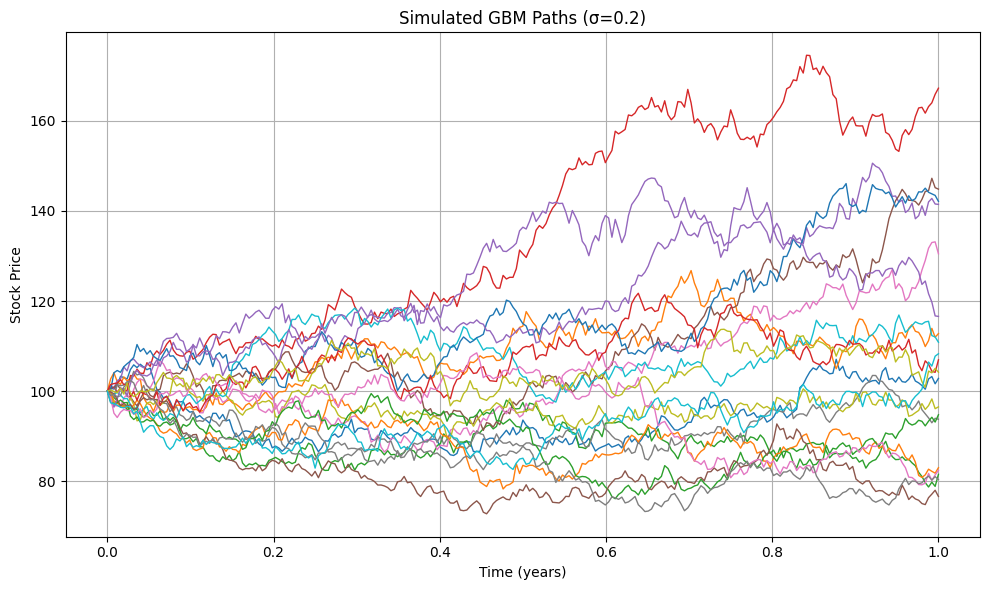

In [2]:
# 模拟参数
S0 = 100
r = 0.06
sigma = 0.2
T = 1.0
N = 252
n_paths = 1000  # 总模拟路径数
n_show = 20     # 展示前 n 条路径

# 生成路径
paths = mcs.simulate_gbm_paths(S0, r, sigma, T, N, n_paths, seed=42)

# 构造时间轴
time_grid = np.linspace(0, T, N + 1)

# 绘图
plt.figure(figsize=(10, 6))
for i in range(n_show):
    plt.plot(time_grid, paths[i], lw=1)

plt.title(f"Simulated GBM Paths (σ={sigma})")
plt.xlabel("Time (years)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\alex\AppData\Local\Temp\ipykernel_26580\4243714400.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colors[idx], len(hedge_steps) * 10)  # 从浅到深的蓝色渐变


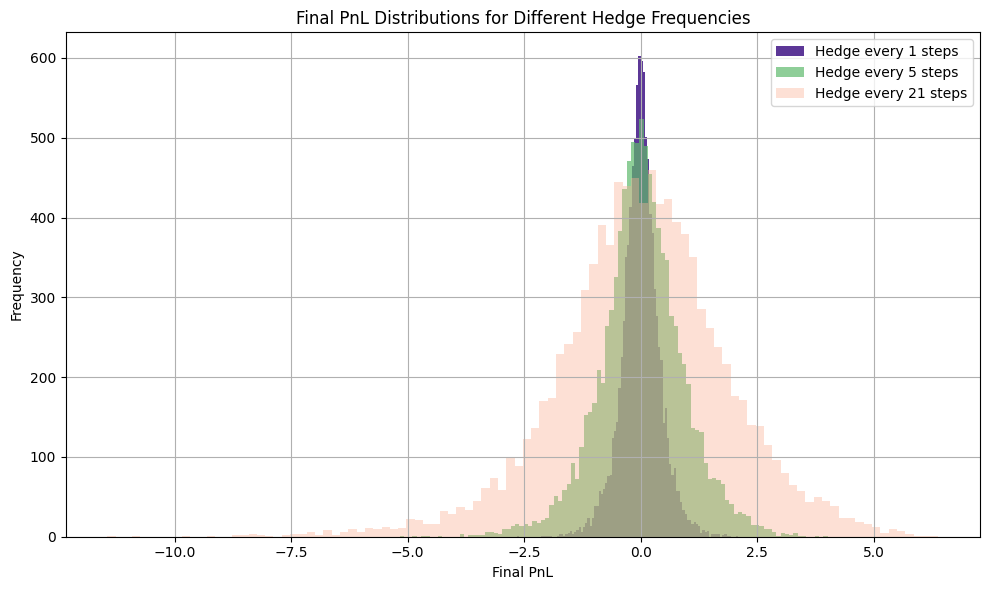


📊 Hedging Frequency Analysis:
    Freq |       Mean |    Std Dev |     Skew |   Kurtosis
-------------------------------------------------------
       1 |   -0.00385 |    0.41757 |   -0.071 |      1.862
       5 |    0.01412 |    0.91119 |   -0.139 |      1.394
      21 |    0.01037 |    1.86142 |   -0.375 |      1.494


In [42]:
import matplotlib.cm as cm

def analyze_task1_hedge_frequencies(
    S0=100, K=99, T=1.0, r=0.06, sigma_real=0.2, sigma_model=0.2,
    N=252, n_paths=10000, hedge_steps=[1, 5, 21]
):
    # 设置颜色
    colors = ['Purples', 'Greens', 'Reds']
    
    # 模拟股票路径（真实市场波动率）
    paths = mcs.simulate_gbm_paths(S0, r, sigma_real, T, N, n_paths, seed=42)

    plt.figure(figsize=(10, 6))
    stats_summary = []

    # for idx, hedge_every in enumerate(hedge_steps):
    #     # 模拟对冲
    #     pnl_paths = pnl.simulate_hedging_pnl(
    #         paths, r, sigma_model, K, T,
    #         black_scholes.bs_call_price, black_scholes.bs_call_delta,
    #         hedge_every=hedge_every
    #     )

    #     final_pnl = pnl_paths[:, -1]

    #     # 绘图
    #     plt.hist(final_pnl, bins=100, alpha=0.5, color=colors[idx],
    #              label=f"Hedge every {hedge_every} steps")

    for idx, hedge_every in enumerate(hedge_steps):
        cmap = cm.get_cmap(colors[idx], len(hedge_steps) * 10)  # 从浅到深的蓝色渐变
        color = cmap(8*(len(hedge_steps) - idx))  # 获取颜色
        alpha = 1 - idx * 0.3  # 如 0.9, 0.6, 0.3

        pnl_paths = pnl.simulate_hedging_pnl(
            paths, r, sigma_model, K, T,
            black_scholes.bs_call_price, black_scholes.bs_call_delta,
            hedge_every=hedge_every
        )

        final_pnl = pnl_paths[:, -1]
        plt.hist(final_pnl, bins=100, alpha=alpha, color=color,
                label=f"Hedge every {hedge_every} steps")
        

        # 统计
        mean = final_pnl.mean()
        std = final_pnl.std()
        sk = skew(final_pnl)
        kt = kurtosis(final_pnl)
        stats_summary.append((hedge_every, mean, std, sk, kt))

    plt.title("Final PnL Distributions for Different Hedge Frequencies")
    plt.xlabel("Final PnL")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 打印统计结果
    print("\n📊 Hedging Frequency Analysis:")
    print(f"{'Freq':>8} | {'Mean':>10} | {'Std Dev':>10} | {'Skew':>8} | {'Kurtosis':>10}")
    print("-" * 55)
    for freq, mean, std, sk, kt in stats_summary:
        print(f"{freq:>8} | {mean:>10.5f} | {std:>10.5f} | {sk:>8.3f} | {kt:>10.3f}")

analyze_task1_hedge_frequencies(
    S0=100, K=99, T=1.0, r=0.06,
    sigma_real=0.2, sigma_model=0.2,
    N=252, n_paths=10000,
    hedge_steps=[1, 5, 21]  # 每日，每周，每月对冲
)


## Task 2 Mismatched Volatility:

C:\Users\alex\AppData\Local\Temp\ipykernel_26580\1430653598.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', n_sigma)


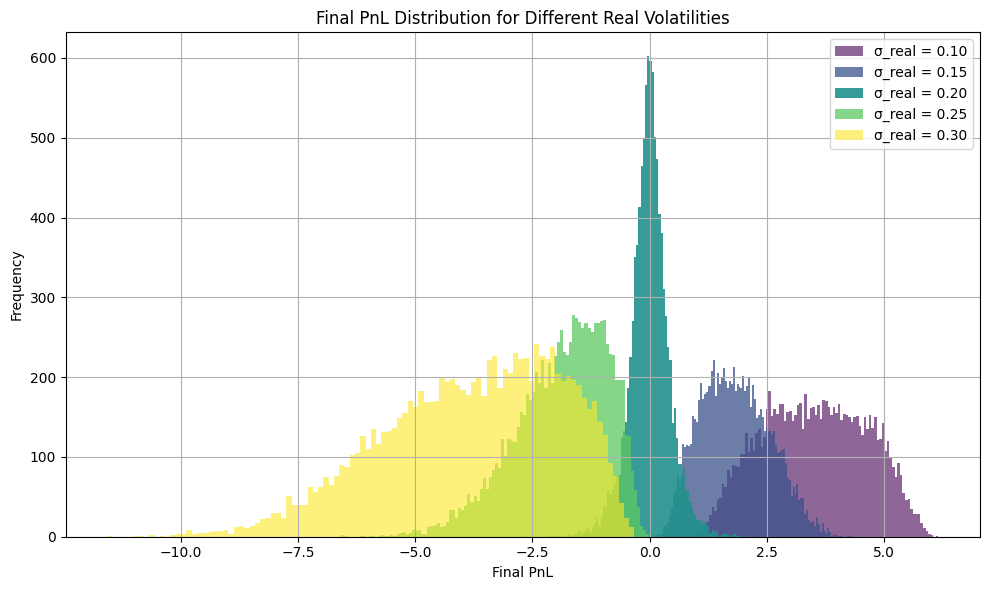


📊 Volatility Mismatch Analysis:
  σ_real |       Mean |    Std Dev |     Skew |   Kurtosis
-------------------------------------------------------
    0.10 |    3.51346 |    1.10022 |   -0.027 |     -0.894
    0.15 |    1.82533 |    0.72940 |    0.264 |     -0.557
    0.20 |   -0.00385 |    0.41757 |   -0.071 |      1.862
    0.25 |   -1.88250 |    0.98504 |   -0.725 |      0.326
    0.30 |   -3.78298 |    1.90114 |   -0.502 |     -0.304


In [45]:
def analyze_task2_vol_mismatch(
    S0=100, K=99, T=1.0, r=0.06, sigma_model=0.2,
    sigma_real_list=[0.10, 0.15, 0.20, 0.25, 0.30],
    N=252, n_paths=10000, hedge_every=1
):
    n_sigma = len(sigma_real_list)
    cmap = cm.get_cmap('viridis', n_sigma)
    stats_summary = []

    plt.figure(figsize=(10, 6))

    for idx, sigma_real in enumerate(sigma_real_list):
        color = cmap(idx)
        alpha = 0.9 - 0.6 * abs(sigma_real - sigma_model) / (max(sigma_real_list) - min(sigma_real_list))

        paths = mcs.simulate_gbm_paths(S0, r, sigma_real, T, N, n_paths, seed=42)
        pnl_paths = pnl.simulate_hedging_pnl(
            paths, r, sigma_model, K, T,
            black_scholes.bs_call_price, black_scholes.bs_call_delta,
            hedge_every=hedge_every
        )
        final_pnl = pnl_paths[:, -1]

        plt.hist(final_pnl, bins=100, alpha=alpha, color=color,
                 label=f"σ_real = {sigma_real:.2f}")

        # 统计量记录
        stats_summary.append((
            sigma_real,
            final_pnl.mean(),
            final_pnl.std(),
            skew(final_pnl),
            kurtosis(final_pnl)
        ))

    # 图像样式
    plt.title("Final PnL Distribution for Different Real Volatilities")
    plt.xlabel("Final PnL")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 输出统计结果
    print("\n📊 Volatility Mismatch Analysis:")
    print(f"{'σ_real':>8} | {'Mean':>10} | {'Std Dev':>10} | {'Skew':>8} | {'Kurtosis':>10}")
    print("-" * 55)
    for sigma, mean, std, sk, kt in stats_summary:
        print(f"{sigma:>8.2f} | {mean:>10.5f} | {std:>10.5f} | {sk:>8.3f} | {kt:>10.3f}")

analyze_task2_vol_mismatch(
    S0=100, K=99, T=1.0, r=0.06,
    sigma_model=0.2,
    sigma_real_list=[0.10, 0.15, 0.20, 0.25, 0.30],
    N=252, n_paths=10000,
    hedge_every=1  # 每日对冲
)


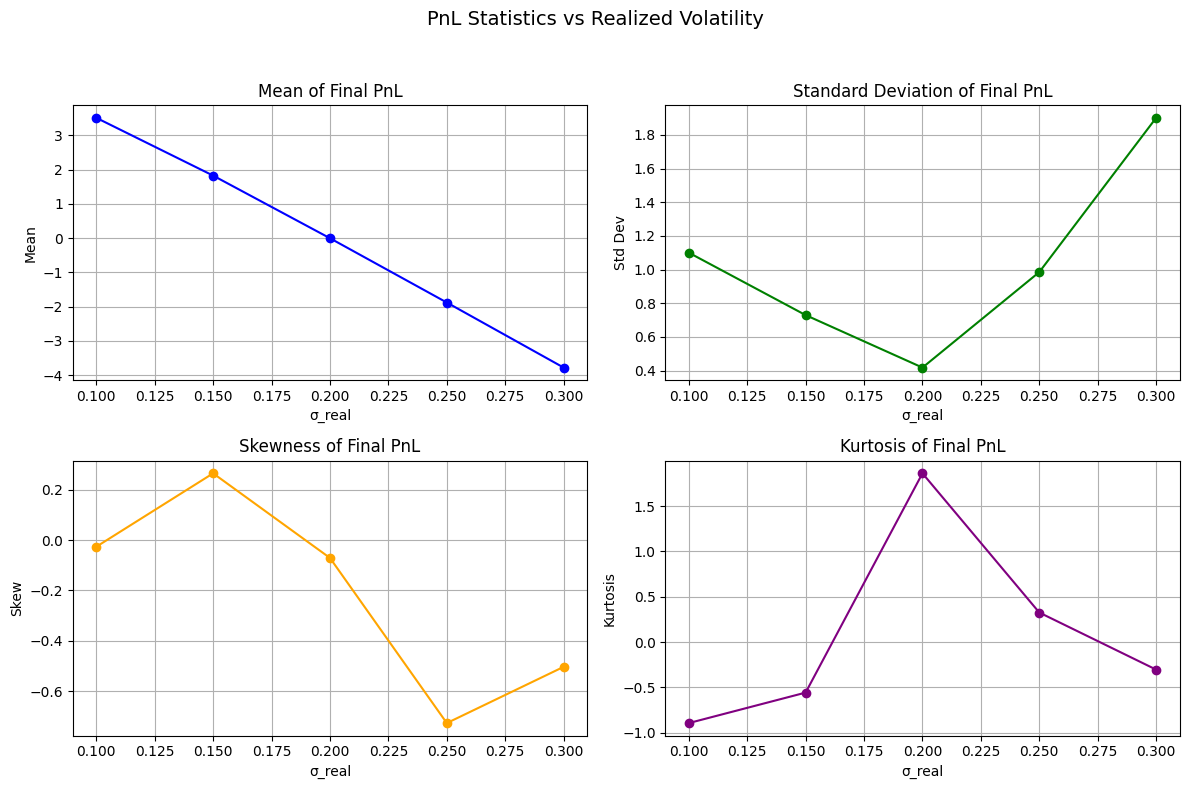

In [48]:
def analyze_task2_vol_mismatch_curves(
    S0=100, K=99, T=1.0, r=0.06, sigma_model=0.2,
    sigma_real_list=[0.10, 0.15, 0.20, 0.25, 0.30],
    N=252, n_paths=10000, hedge_every=1
):
    means, stds, skews, kurts = [], [], [], []

    for sigma_real in sigma_real_list:
        paths = mcs.simulate_gbm_paths(S0, r, sigma_real, T, N, n_paths, seed=42)
        pnl_paths = pnl.simulate_hedging_pnl(
            paths, r, sigma_model, K, T,
            black_scholes.bs_call_price, black_scholes.bs_call_delta,
            hedge_every=hedge_every
        )
        final_pnl = pnl_paths[:, -1]

        means.append(final_pnl.mean())
        stds.append(final_pnl.std())
        skews.append(skew(final_pnl))
        kurts.append(kurtosis(final_pnl))

    # 开始画图（每张一幅图）
    x = sigma_real_list
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    axes[0].plot(x, means, marker='o', color='blue')
    axes[0].set_title("Mean of Final PnL")
    axes[0].set_ylabel("Mean")

    axes[1].plot(x, stds, marker='o', color='green')
    axes[1].set_title("Standard Deviation of Final PnL")
    axes[1].set_ylabel("Std Dev")

    axes[2].plot(x, skews, marker='o', color='orange')
    axes[2].set_title("Skewness of Final PnL")
    axes[2].set_ylabel("Skew")

    axes[3].plot(x, kurts, marker='o', color='purple')
    axes[3].set_title("Kurtosis of Final PnL")
    axes[3].set_ylabel("Kurtosis")

    for ax in axes:
        ax.set_xlabel("σ_real")
        ax.grid(True)

    plt.suptitle("PnL Statistics vs Realized Volatility", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

analyze_task2_vol_mismatch_curves(
    S0=100, K=99, T=1.0, r=0.06,
    sigma_model=0.2,
    sigma_real_list=[0.10, 0.15, 0.20, 0.25, 0.30],
    N=252, n_paths=10000,
    hedge_every=1
)